<a href="https://colab.research.google.com/github/Sergeichik/MLDM-2023/blob/main/09-neural-networks/NNs_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim import Adam
import tqdm

# Task 1: maximum likelihood fit (3 points)

Let's generate a Gaussian mixture dataset and then fit its parameters with maximum likelihood.

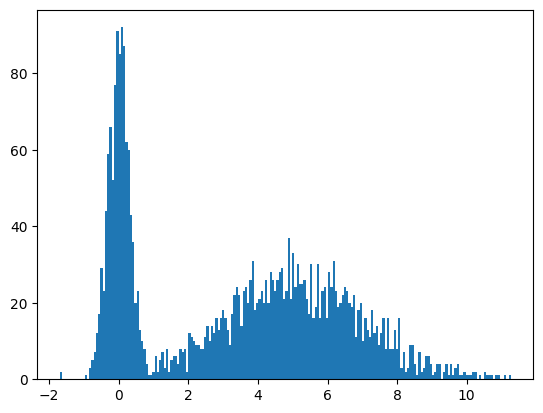

In [5]:
X1 = np.random.normal(size=1000, scale=0.3).astype('float32')
X2 = np.random.normal(size=2000, loc=5., scale=2.).astype('float32')

X = np.concatenate([X1, X2])
np.random.shuffle(X)

plt.hist(X, bins=200);

**Task**:
 - fill the gaps below to perform the max. likelihood fit with the pdf:
$$\text{PDF}(x|\mu_1, \sigma^2_1, \mu_2, \sigma^2_2, \alpha)
= \alpha\cdot\mathscr{N}(x|\mu_1, \sigma_1^2) + (1 - \alpha)\cdot\mathscr{N}(x|\mu_2, \sigma_2^2)$$
 - what the fitted values of $\mu_1, \sigma^2_1, \mu_2, \sigma^2_2$ and $\alpha$ should be? does your fit converge to them?

In [6]:
X = torch.from_numpy(X)

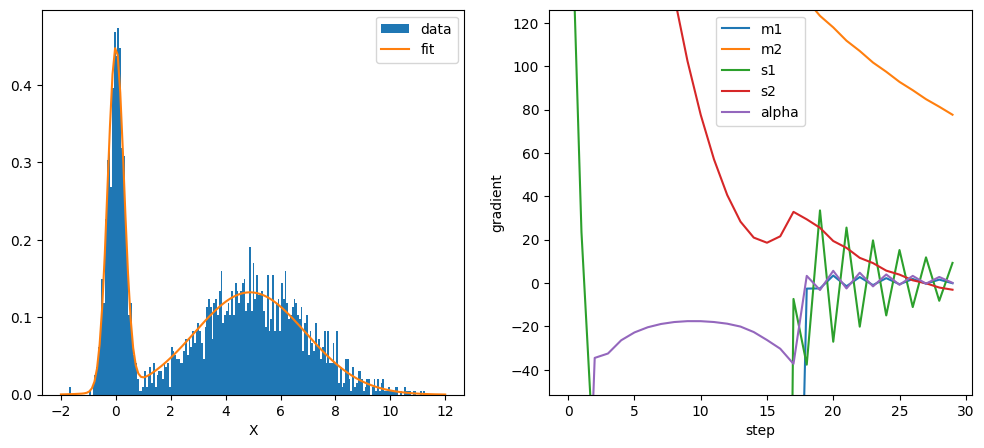

In [7]:
from IPython.display import clear_output



# Defining Gaussian PDF using torch functions
def gaussian(x, mu, sigma):
    return torch.exp(-.5 * ((x - mu) / sigma) ** 2) / (sigma * torch.sqrt(torch.Tensor([2 * torch.pi])))
   # use torch.exp for the exponent, don't forget the normalization

# Arbitrary mixture PDF
def mixture(x, f1, f2, alpha):
  return alpha * f1(x) + (1. - alpha) * f2(x)

# Parameters that we'd like to infer (with an initial guess)
m1    = torch.tensor([1.0], requires_grad=True)
m2    = torch.tensor([4.0], requires_grad=True)
s1    = torch.tensor([1.0], requires_grad=True)
s2    = torch.tensor([1.0], requires_grad=True)
alpha = torch.tensor([0.5], requires_grad=True)

# At each gradient update we'll apply this function to
# ensure valid parameter values
def apply_constraints():
  with torch.no_grad():
      torch.clamp_(s1, min=1e-5) # ensure the sigmas are positive (greater or equal to some small
      torch.clamp_(s2, min=1e-5)
      torch.clamp_(alpha, min=0, max=1) # positive number, e.g. 1e-5) and alpha is in (0, 1) interval


variables = [m1, m2, s1, s2, alpha]

# Defining the overall PDF
def model_pdf(x):
  return mixture(x,
                 lambda t: gaussian(t, m1, s1),
                 lambda t: gaussian(t, m2, s2),
                 alpha)

# Log likelihood
def loglike(x):
    return torch.sum(torch.log(model_pdf(x) + 1e-10))

learning_rate = 0.0001
grad_history = [] # to keep track of gradient values at different steps

for i in range(30):
  # Forward pass:
  l = loglike(X)

  # Backprop
  l.backward()
  # Gradient ascent step

  grad_history.append([var.grad.item() for var in variables])

  with torch.no_grad():
        for var in variables:
            var += learning_rate * var.grad
            var.grad.zero_()

  apply_constraints()



  ############################
  # Do some plotting
  plt.figure(figsize=(12, 5))

  plt.subplot(1, 2, 1)
  plt.hist(X, bins=200, density=True, label='data')
  x_grid = torch.from_numpy(np.linspace(-2, 12, 150))
  plt.plot(x_grid, model_pdf(x_grid).detach(), label='fit')
  plt.legend()
  plt.xlabel('X')

  plt.subplot(1, 2, 2)
  lines = plt.plot(np.array(grad_history))
  low = min(grad_history[-1])
  high = max(grad_history[-1])
  plt.ylim(low  - (high - low) * 0.6,
           high + (high - low) * 0.6)
  plt.legend(lines, ['m1', 'm2', 's1', 's2', 'alpha'])
  plt.xlabel('step')
  plt.ylabel('gradient')
  plt.show()
  clear_output(wait=True);

In [8]:
variables

[tensor([-0.0005], requires_grad=True),
 tensor([4.8892], requires_grad=True),
 tensor([0.2970], requires_grad=True),
 tensor([2.0247], requires_grad=True),
 tensor([0.3292], requires_grad=True)]

my fit converges to them

# Task 2: classifying clothes (3 points)

In [9]:
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5), (0.5))
                               ])

# Download and load the training data
trainset = datasets.FashionMNIST('MNIST_data/', download = True, train = True, transform = transform)
testset = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = True)
testloader = torch.utils.data.DataLoader(testset, batch_size = 64, shuffle = True)

100%|██████████| 26421880/26421880 [00:01<00:00, 13562810.24it/s]


Extracting MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 203960.90it/s]


Extracting MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3748384.53it/s]


Extracting MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6256817.44it/s]

Extracting MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



[['Pullover' 'Sandal' 'Pullover' 'Dress' 'T-shirt/top' 'Bag' 'Bag'
  'Sneaker']
 ['Shirt' 'Shirt' 'Shirt' 'Sneaker' 'Shirt' 'Trouser' 'Coat' 'Sneaker']
 ['Ankle boot' 'Coat' 'Dress' 'Pullover' 'Trouser' 'Sandal' 'Trouser'
  'Pullover']
 ['Coat' 'Pullover' 'Dress' 'Pullover' 'Pullover' 'Dress' 'T-shirt/top'
  'Pullover']
 ['Sneaker' 'Coat' 'Pullover' 'Sandal' 'Dress' 'Pullover' 'Sandal'
  'Shirt']
 ['Pullover' 'Sandal' 'Pullover' 'Shirt' 'Ankle boot' 'Ankle boot'
  'Sneaker' 'Trouser']
 ['Trouser' 'T-shirt/top' 'T-shirt/top' 'T-shirt/top' 'Ankle boot' 'Coat'
  'Shirt' 'Coat']
 ['Trouser' 'Sandal' 'Pullover' 'Sandal' 'Coat' 'T-shirt/top' 'Shirt'
  'Ankle boot']]


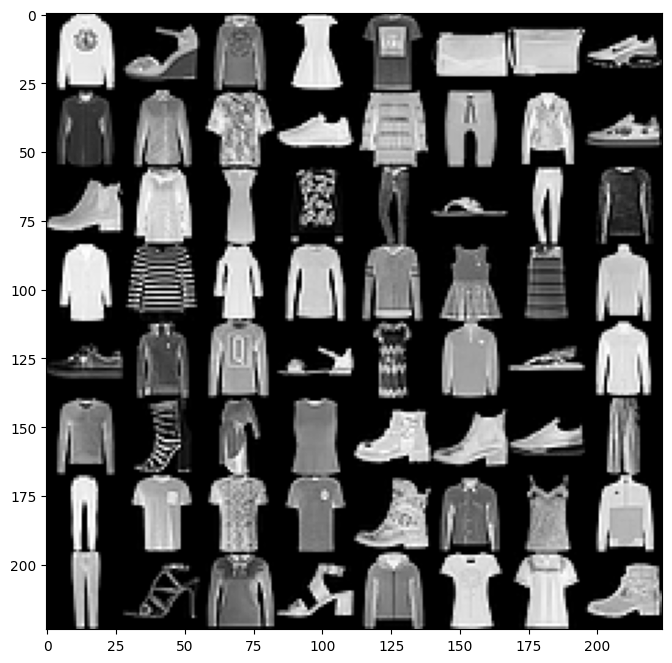

In [10]:
# Array for decoding the categories
label_names = np.array(['T-shirt/top',
                        'Trouser',
                        'Pullover',
                        'Dress',
                        'Coat',
                        'Sandal',
                        'Shirt',
                        'Sneaker',
                        'Bag',
                        'Ankle boot'])

# Get a single data batch of 64 images
sample_images, sample_labels = next(iter(trainloader))

# Plot the images in a 8x8 grid
plt.figure(figsize=(8, 8))
plt.grid(visible=False)
plt.imshow(
    sample_images.numpy().reshape(8, 8, 28, 28).transpose((0, 2, 1, 3)).reshape(224, 224),
    cmap='gray'
)
# Print corresponding labels
print(label_names[sample_labels.numpy().reshape(8, 8)])

**Task**:

Train a model which is an average of two models with different numbers of layers on the Fashion MNIST dataset, e.g.:

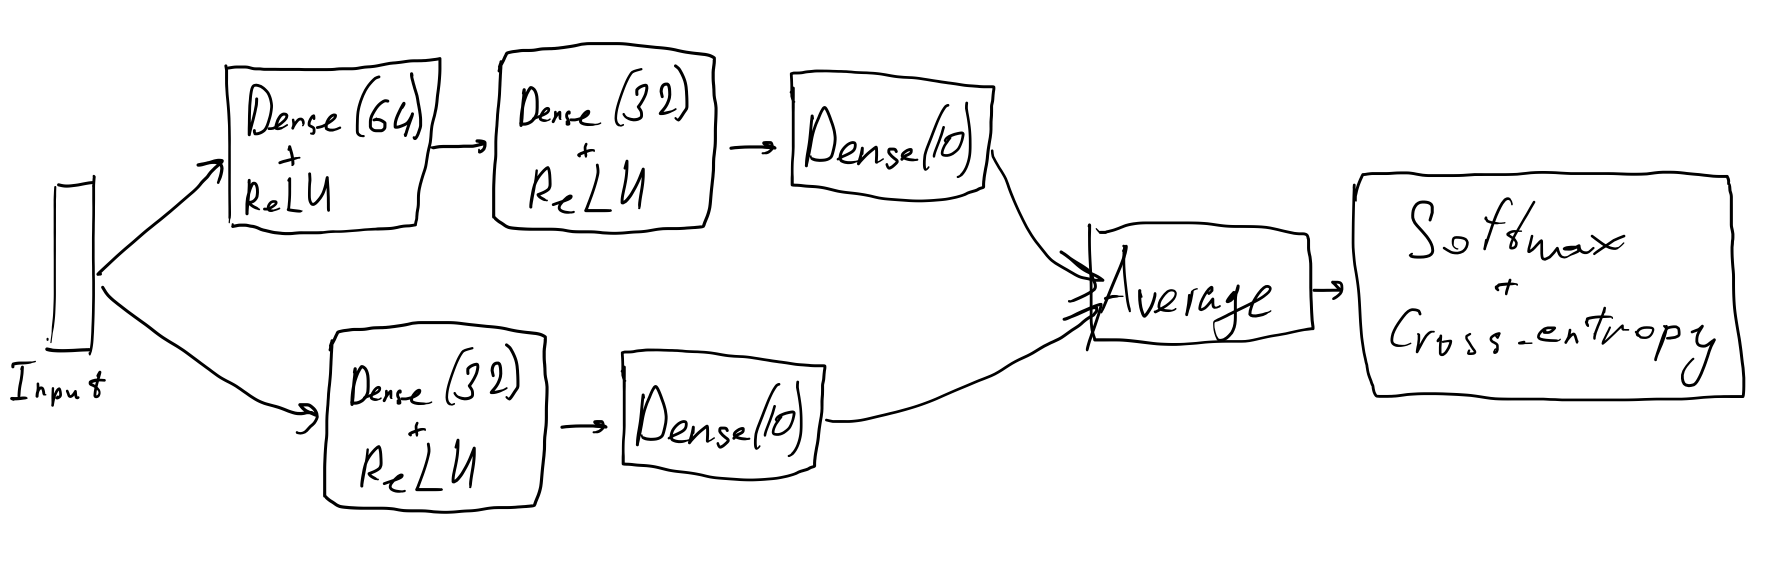

In [15]:
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.ufc1 = nn.Linear(28 * 28, 64)
        self.ufc2 = nn.Linear(64, 32)
        self.ufc3 = nn.Linear(32, 10)
        self.dfc1 = nn.Linear(28 * 28, 32)
        self.dfc2 = nn.Linear(32, 10)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.flatten(x)
        x1 = self.relu(self.ufc1(x))
        x1 = self.relu(self.ufc2(x1))
        x1 = self.ufc3(x1)
        x2 = self.relu(self.dfc1(x))
        x2 = self.dfc2(x2)
        x = (x1 + x2) / 2.
        return x

100%|██████████| 938/938 [00:15<00:00, 61.85it/s]


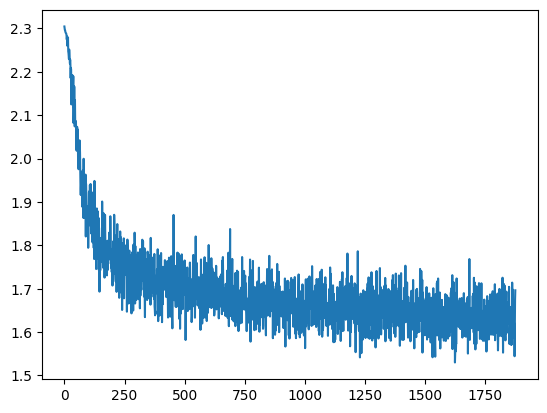

In [18]:
softmax = nn.Softmax(dim=1)
def train_model(model,
                num_epochs=2,
                lr=3e-4,
                device='cuda:0'):

    model.train()
    model = model.to(device)

    dataloader = trainloader

    optimizer = Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    losses = []
    for epoch in range(num_epochs):
        for batch in tqdm.tqdm(dataloader):
            xs, ys_true = batch
            optimizer.zero_grad()
            logits_pred = softmax(model(xs.to(device)))

            loss = criterion(logits_pred, ys_true.to(device))
            loss.backward()
            optimizer.step()


            losses.append(loss.item())

    return losses
losses = train_model(MyNet(), num_epochs=2)
plt.plot(losses)
plt.show()